In [ ]:
using LinearAlgebra
using LaTeXStrings
using FFTW
t1 = 1.0 # hopping amplitude between nearest neighbours
t2 = 0.0 # hoppping amplitude between second nearest neighbours ...
t3 = 0.00
t4 = 0.000
t_fixed = true 
t1 = t_fixed ? t1 : collect((range(0.0,t1,30))) # uvolnit pro vykreslení závislosti na amplitudě přeskoků 
t2 = t_fixed ? t2 : collect((range(0.0,t2,30)))  
t3 = t_fixed ? t3 : collect((range(0.0,t3,30))) 
t4 = t_fixed ? t4 : collect((range(0.0,t4,30))) 
t = [t1,t2,t3,t4]

D = 2.0 # (Delta) crystal field coefficient, a-sites are at +D, b-sites are at -D 
N = 10  # number of sites, must be even (so there's a k-vector equal to zero)
V_fixed = false   
V = V_fixed ? 2.0 : collect(range(0.0,5.0,50)) # uvolnit pro vykreslení závislosti na amplitudě interakce

using Plots
Plots.default(
    size=(840, 530),
    tickfontsize=14,   # Increase tick label size
    guidefontsize=16,  # Increase axis label font size
    legendfontsize=14  # Increase legend font size
)

In [2]:
struct Zn
    val::Int64
    Zn(a::Int64) = new(mod(a,N))
end

Base.:+(a::Zn, b::Zn) = Zn(mod(a.val + b.val, N))
Base.:-(a::Zn, b::Zn) = Zn(mod(a.val - b.val, N))

In [3]:
index(a::Zn) = a.val + 1

index (generic function with 1 method)

In [4]:
K = Vector{Zn}(undef,N) # k-vector
for i in 1:N
    K[i] = Zn(i-1)
end
K_vals = [k.val for k in K]
shifted_K_vals = [k.val - N/2 for k in K]

60-element Vector{Float64}:
 -30.0
 -29.0
 -28.0
 -27.0
 -26.0
 -25.0
 -24.0
 -23.0
 -22.0
 -21.0
   ⋮
  21.0
  22.0
  23.0
  24.0
  25.0
  26.0
  27.0
  28.0
  29.0

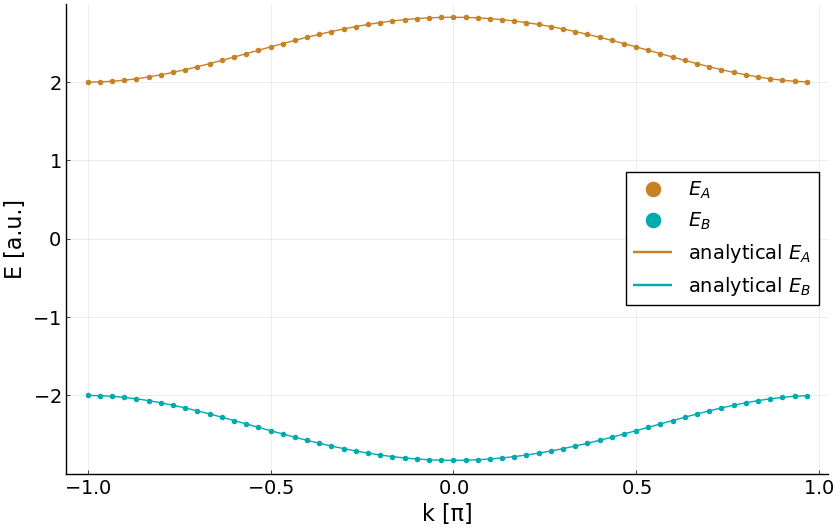

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [5]:
# hamiltonián pro dané k a t umožňující přes něj počítat závislosti na V i t
h(N::Int64,K::Zn,t1::Float64,t2::Float64) = [-D t1*(1+exp(-im*2*pi/N*K.val)); t1*(1+exp(im*2*pi/N*K.val)) D] + 2*t2*[cos(K.val*2*pi/N) 0; 0 cos(K.val*2*pi/N)]

function eig_fun(N::Int64,K::Vector{Zn},h::Function,t1::Float64,t2::Float64) #počet buněk, vektor k, hamiltonián, amplituda přeskoků
E_A = zeros(N)
E_B = zeros(N)
v_B = zeros(Complex{Float64},2,N) #vlastní vektory s vlastními energiemi B
v_A = zeros(Complex{Float64},2,N) #vlastní vektory s vlastními energiemi A
a1 = zeros(Complex{Float64}, N) 
b1 = zeros(Complex{Float64}, N) 
a2 = zeros(Complex{Float64}, N) 
b2 = zeros(Complex{Float64}, N)
    for i in 1:N  #stejně potřebuju i indexy
        eig = eigen(h(N,K[i],t1,t2)) #spočítá se pro všechna k
        E_B[i] = eig.values[1] #eigen() returns eigenvalues from lower to higher ones, so the first value is of the B-band
        E_A[i] = eig.values[2]
        v_B[:,i] .= eig.vectors[:,1] 
        v_A[:,i] .= eig.vectors[:,2] 
        b2[i] = (v_B[1,i])
        b1[i] = (v_B[2,i])
        a2[i] = (v_A[1,i])
        a1[i] = (v_A[2,i])
    end
return E_A, E_B, b2, b1, a1, a2, v_A, v_B #raději vracím vše
end

if t_fixed == true
band_structure = eig_fun(N,K,h,t[1],t[2]) #výpočet energií a vektorů pro dané t1,t2
E_A, E_B, b2, b1, a1, a2, v_A, v_B = band_structure




#plotting A and B bands
using Plots
pythonplot()
scatter(shifted_K_vals*2/N, fftshift(E_A), label  = L"E_A", markerstrokewidth=0, color=palette(:auto)[8])
scatter!(shifted_K_vals*2/N, fftshift(E_B), label = L"E_B", markerstrokewidth=0, color = palette(:auto)[6])
plot!(shifted_K_vals*2/N, 2*t[2]*cos.(shifted_K_vals*2*pi/N) + sqrt.(2*t[1]^2*(1 .+ cos.(shifted_K_vals*2*pi/N)) .+ D^2),label=L"\text{analytical } E_A", color=palette(:auto)[8]) #,legend_position=(0.37, 0.34)
plot!(shifted_K_vals*2/N, 2*t[2]*cos.(shifted_K_vals*2*pi/N) - sqrt.(2*t[1]^2*(1 .+ cos.(shifted_K_vals*2*pi/N)) .+ D^2), label=L"\text{analytical } E_B", color=palette(:auto)[6])
plot!(legend=:right)
xlabel!("k [π]")
ylabel!("E [a.u.]")
#savefig("band_structure_t1=1_D=2_N=40.png")
end

In [6]:
#defining matrix elements in the ground state
BBBB_0(K::Vector{Zn},a1,a2,b1,b2,R::Int64) = sum(abs2(b1[index(l)]) for l in K) * sum(abs2(b2[index(l)]) for l in K) #chybí smíšený člen nebo ne?  #-sum(exp(im*R*q.val*2*pi/N) * conj(b1[index(l)]) * b1[index(l+q)] * conj(b2[index(l+q)]) * b2[index(l)] for l in K for q in K)

BAAB_0(K::Vector{Zn},a1,a2,b1,b2,R::Int64) = sum(exp(-im*R*q.val*2*pi/N) * conj(b1[index(l)]) * a1[index(l+q)] * conj(a2[index(l+q)]) * b2[index(l)] for l in K for q in K)

#defining diagonal matrix elements in the excited states
AAAA(K::Vector{Zn},k::Zn,Q::Zn,a1,a2,b1,b2,R::Int64) = 0*conj(a1[index(k+Q)]) * a2[index(k+Q)] * sum(exp(-im*R*q.val*2*pi/N) * a1[index(k+Q+q)] * conj(a2[index(k+Q+q)]) for q in K)

ABBA(K::Vector{Zn},k::Zn,Q::Zn,a1,a2,b1,b2,R::Int64) = 0*exp(im*R*Q.val*2*pi/N) * conj(a1[index(k+Q)]) * b1[index(k)] * conj(b2[index(k)]) * a2[index(k+Q)]

BBAA(K::Vector{Zn},k::Zn,Q::Zn,a1,a2,b1,b2,R::Int64) = 0*abs2(a2[index(k+Q)]) * (sum(abs2(b1[index(l)]) for l in K) - abs2(b1[index(k)]))

AABB(K::Vector{Zn},k::Zn,Q::Zn,a1,a2,b1,b2,R::Int64) = 0*abs2(a1[index(k+Q)]) * (sum(abs2(b2[index(l)]) for l in K) - abs2(b2[index(k)]))

BAAB(K::Vector{Zn},k::Zn,Q::Zn,a1,a2,b1,b2,R::Int64) = (0*a1[index(k+Q)] * conj(a2[index(k+Q)]) * (exp(-im*R*Q.val*2*pi/N) * conj(b1[index(k)]) * b2[index(k)] 
                                                    - 0*sum(exp(im*R*q.val*2*pi/N) * conj(b1[index(k+Q+q)]) * b2[index(k+Q+q)] for q in K))
                                                    + sum(exp(-im*R*q.val*2*pi/N) * conj(b1[index(l)]) * a1[index(l+q)] * conj(a2[index(l+q)]) * b2[index(l)] for l in K for q in K)
                                                    - 0*conj(b1[index(k)]) * b2[index(k)] * sum(exp(-im*R*q.val*2*pi/N) * a1[index(k+q)] * conj(a2[index(k+q)]) for q in K))

BBBB(K::Vector{Zn},k::Zn,Q::Zn,a1,a2,b1,b2,R::Int64) = (0*b1[index(k)] * conj(b2[index(k)]) * sum(exp(im*R*q.val*2*pi/N) * conj(b1[index(k+q)]) * b2[index(k+q)] for q in K)
                                                     - 0*abs2(b2[index(k)]) * sum(abs2(b1[index(l)]) for l in K) - 0*abs2(b1[index(k)]) * sum(abs2(b2[index(l)]) for l in K) 
                                                     + sum(abs2(b1[index(l)]) for l in K) * sum(abs2(b2[index(l)]) for l in K))

#defining offdiagonal matrix elements in the excited states
ABBAoff(k1::Zn,k2::Zn,Q::Zn,a1,a2,b1,b2,R::Int64) = exp(im*R*Q.val*2*pi/N) * conj(a1[index(k1+Q)]) * b1[index(k1)] * conj(b2[index(k2)]) * a2[index(k2+Q)]

BBAAoff(k1::Zn,k2::Zn,Q::Zn,a1,a2,b1,b2,R::Int64) = -exp(-im*R*(k1-k2).val*2*pi/N) * conj(b1[index(k2)]) * b1[index(k1)] * conj(a2[index(k1+Q)]) * a2[index(k2+Q)]

AABBoff(k1::Zn,k2::Zn,Q::Zn,a1,a2,b1,b2,R::Int64) = -exp(-im*R*(k2-k1).val*2*pi/N) * conj(a1[index(k1+Q)]) * a1[index(k2+Q)] * conj(b2[index(k2)]) * b2[index(k1)]

BAABoff(k1::Zn,k2::Zn,Q::Zn,a1,a2,b1,b2,R::Int64) = exp(-im*R*Q.val*2*pi/N) * conj(b1[index(k2)]) * a1[index(k2+Q)] * conj(a2[index(k1+Q)]) * b2[index(k1)]

#defining occupation number operators
nak(K::Vector{Zn},k::Zn,Q::Zn,a1,a2,b1,b2) = 1/N*(0*abs2(a1[index(k+Q)]) + sum(abs2(b1[index(l)]) for l in K) - 0*abs2(b1[index(k)]))
nbk(K::Vector{Zn},k::Zn,Q::Zn,a1,a2,b1,b2) =  1/N*(0*abs2(a2[index(k+Q)]) + sum(abs2(b2[index(l)]) for l in K) - 0*abs2(b2[index(k)]))

nbk (generic function with 1 method)

In [18]:

function diagonal_interaction(K::Vector{Zn},k::Zn,Q::Zn,a1,a2,b1,b2)
    R_0 = (AAAA(K,k,Q,a1,a2,b1,b2,0) + ABBA(K,k,Q,a1,a2,b1,b2,0) + BBAA(K,k,Q,a1,a2,b1,b2,0) + AABB(K,k,Q,a1,a2,b1,b2,0) + BAAB(K,k,Q,a1,a2,b1,b2,0) 
        + BBBB(K,k,Q,a1,a2,b1,b2,0) - BBBB_0(K,a1,a2,b1,b2,0) - BAAB_0(K,a1,a2,b1,b2,0)) #without interaction in the ground state
    R_1 = 0*(AAAA(K,k,Q,a1,a2,b1,b2,-1) + ABBA(K,k,Q,a1,a2,b1,b2,-1) + BBAA(K,k,Q,a1,a2,b1,b2,-1) + AABB(K,k,Q,a1,a2,b1,b2,-1) + BAAB(K,k,Q,a1,a2,b1,b2,-1) 
        + BBBB(K,k,Q,a1,a2,b1,b2,-1) - BBBB_0(K,a1,a2,b1,b2,-1) - BAAB_0(K,a1,a2,b1,b2,-1)) #with interaction in the ground state
    return (R_0 + R_1)
end

function fill_H(K::Vector{Zn},Q::Zn,a1::Vector{Complex{Float64}},a2::Vector{Complex{Float64}},b1::Vector{Complex{Float64}},b2::Vector{Complex{Float64}},N::Int64,E_A::Vector{Float64},E_B::Vector{Float64},V::Float64) #hamiltonián H v bázi (B A) pro konkrétní V
    H = zeros(Complex{Float64},N,N)
    for k1 in K
        for k2 in K
            if k1 == k2
                k=k1
                H[index(k),index(k)] = E_A[index(k+Q)]-E_B[index(k)] + V/N*diagonal_interaction(K,k,Q,a1,a2,b1,b2) 
            else 
                H[index(k1),index(k2)] = V/N*(ABBAoff(k1,k2,Q,a1,a2,b1,b2,0) + BBAAoff(k1,k2,Q,a1,a2,b1,b2,0) + AABBoff(k1,k2,Q,a1,a2,b1,b2,0) + BAABoff(k1,k2,Q,a1,a2,b1,b2,0)  
                    + ABBAoff(k1,k2,Q,a1,a2,b1,b2,1) + BBAAoff(k1,k2,Q,a1,a2,b1,b2,1) + AABBoff(k1,k2,Q,a1,a2,b1,b2,1) + BAABoff(k1,k2,Q,a1,a2,b1,b2,1))
            end
        end
    end
    return H
end


function diagonalize_H(K::Vector{Zn},Q::Zn,N,t1,V,h::Function)
    Diag = zeros(Complex{Float64},N,1)
    Vecs = zeros(Complex{Float64},N,N)
    H = zeros(Complex{Float64},N,N)
    for i in 1:length(t1)  # pokud t bude zafixované, projede se cyklus jen jednou; bereme NN a NNN, proto t[1] a t[2] viz definování na začátku kódu
        band = eig_fun(N,K,h,t1[i],0.0) #nakonec mě zajímá jen NN stejně teď
        E_A = band[1]
        E_B = band[2]
        b2 = band[3] 
        b1 = band[4] 
        a1 = band[5]
        a2 = band[6]
        for j in 1:length(V)
            H = fill_H(K,Q,a1,a2,b1,b2,N,E_A,E_B,V[j])
            Eig = eigen(H)
            if j == 1 && i == 1
                Diag .= Eig.values
                Vecs .= Eig.vectors
            else Diag = hcat(Diag, Eig.values)
            end
        end
    end
        return Diag, Vecs, H, E_A, E_B, a1, a2, b1, b2 #posledních 7 na korelační funkci
end

diagonalize_H (generic function with 1 method)

In [19]:
#defining for which Q we will computate H
Q = Zn(0) #index -> zadat jako číslo od 0 do N-1
Diag = diagonalize_H(K,Q,N,t[1],V,h)[1]
Vecs = diagonalize_H(K,Q,N,t[1],V,h)[2]

#vykreslování E(V,Q) a E(t,Q) 
using Plots
pythonplot()
if (t_fixed == true && V_fixed == false)
    plot(V, real(Diag'), label = "") #,title = "t = $(t[1]), Q = $(Q.val*2/N) π"
    xlabel!("V")
    ylabel!("E [a.u.]")
elseif (V_fixed == true && t_fixed == false)
    plot(t[1], real(Diag'),label = "") #title = "V = $(V), Q = $(Q.val*2/N) π", 
    xlabel!("t")
    ylabel!("E [a.u.]")
end


Plots.default(
    tickfontsize=30,   # Increase tick label size
    guidefontsize=40,  # Increase axis label font size
    legendfontsize=30  # Increase legend font size
)
plot!(size=(1440, 1080))  # Bigger image

savefig("E(t)_V=2_Q=0_N=100_D=2.png")



"c:\\Users\\micha\\OneDrive - MUNI\\Obrázky\\Plocha\\bakalářka\\E(t)_V=2_Q=0_N=100_D=2.png"

In [ ]:
#vykreslení disperze
if t_fixed == true && V_fixed == true
    dispersion = zeros(Float64,N, N)
    for Q in K #index
       Diag = diagonalize_H(K,Q,N,t[1],V,h)[1]
       dispersion[index(Q),:] .= real(Diag)
    end
    
    using Plots
    pythonplot()
    plot(K_vals*2/N,(dispersion), label  = "") # title = "V = $(V), t = $(t[1])",
    xlabel!("Q [π]")
    ylabel!("E [a.u.]")
    end
    

Plots.default(
    tickfontsize=30,   # Increase tick label size
    guidefontsize=40,  # Increase axis label font size
    legendfontsize=30  # Increase legend font size
)
plot!(size=(1440, 1080))  # Bigger image

savefig("E(Q)_t=1_V=2_N=100_D=2.png")

    

In [ ]:
#zadefinování korelační funkce pro dané R
if t_fixed == true && V_fixed == true
    Q = Zn(1)
    prep = diagonalize_H(K,Q,N,t[1],V,h)
    Diag = prep[1]
    Vecs = prep[2]
    H = prep[3]
    E_A = prep[4]
    E_B = prep[5]
    a1 = prep[6]
    a2 = prep[7]
    b1 = prep[8]
    b2 = prep[9]
    
    function C(R,Vecs,a1,a2,b1,b2,N,K::Vector{Zn},Q::Zn) #korelační funkce, je opsaná podle interakce W, ale z ní už je vyjmutá část interakce v základním tvaru -> chyba???
        M = zeros(Complex{Float64},N,N)
        for k1 in K 
            for k2 in K 
                if k1 ==k2
                    k = k1
                    M[index(k),index(k)] = (1/N^2*(AAAA(K,k,Q,a1,a2,b1,b2,R) + ABBA(K,k,Q,a1,a2,b1,b2,R) + BBAA(K,k,Q,a1,a2,b1,b2,R) + AABB(K,k,Q,a1,a2,b1,b2,R) + BAAB(K,k,Q,a1,a2,b1,b2,R) 
                    + BBBB(K,k,Q,a1,a2,b1,b2,R))
                    -nak(K,k,Q,a1,a2,b1,b2)*nbk(K,k,Q,a1,a2,b1,b2) # -<n_a><n_b> ale nějak moc malé
                    )
                else
                    M[index(k1),index(k2)] = 1/N^2*(ABBAoff(k1,k2,Q,a1,a2,b1,b2,R) + BBAAoff(k1,k2,Q,a1,a2,b1,b2,R) + AABBoff(k1,k2,Q,a1,a2,b1,b2,R) + BAABoff(k1,k2,Q,a1,a2,b1,b2,R))
            end
        end
        end
        transformed_M = Vecs' * M * Vecs
        return diag(transformed_M), M
    end
        
    #soubor korelačních funkcí pro všechny vl. stavy a všechna R
    R_vector = collect(-N:N-1)
    L = length(R_vector)
    correlation = zeros(Float64,L,N)
    for R in R_vector
        correlation[R+abs(minimum(R_vector))+1,:] .= real(C(R,Vecs,a1,a2,b1,b2,N,K,Q)[1])
    end
    
    
    function C0(R,Vecs,a1,a2,b1,b2,N,K::Vector{Zn},Q::Zn)
        return (1/N^2*(BBBB_0(K,a1,a2,b1,b2,R) + BAAB_0(K,a1,a2,b1,b2,R)) - 1/N^2*sum(abs2(b1[index(l)]) for l in K)*sum(abs2(b2[index(l)]) for l in K)) #last one from -<0|n_a|O>*<0|n_b|O>
        #má tam být prefaktor 1/N^3? Že 1/N^2 z těch sum a ještě jedno 1/N z celé korelační funkce
    end
    
    C0_vec = zeros(Complex{Float64},L)
    for i in 1:length(R_vector)
        C0_vec[i] = C0(R_vector[i],Vecs,a1,a2,b1,b2,N,K,Q)
    end
    end 
    
    C(11,Vecs,a1,a2,b1,b2,N,K,Q)[1]

In [ ]:
#korelační funkce v základním stavu
using Plots
pythonplot()
plot(R_vector, real(C0_vec), title = "C0", label = "", xlabel = "R", ylabel = "C0")

    

In [ ]:
#vykreslení korelační funkce

if t_fixed == true && V_fixed == true
    using Plots
    pythonplot()
    plot(R_vector,correlation, xlabel = "X", ylabel = "C(X)", label = "") #, title = "V = $(V), t = $(t[1]), Q = $(Q.val*2/N) π"
    end



    Plots.default(
        tickfontsize=30,   # Increase tick label size
        guidefontsize=40,  # Increase axis label font size
        legendfontsize=30  # Increase legend font size
    )
    plot!(size=(1440, 1080))  # Bigger image   
    #savefig("C(X)_Q=0_N=100_t=1_D=2_Vzoom=2.png")


In [13]:
#C(R)-C0
#=
if t_fixed == true && V_fixed == true
    using Plots
    pythonplot()
    plot(R_vector,correlation.-real(C0_vec), title = "V = $(V), t = $(t[1]), Q = $(Q.val*2/N) π", xlabel = "R", ylabel = "C(R)-C0", label = "")
    end
  =#      